# 🍀 Introducing

Competition: [NBME - Score Clinical Patient Notes](https://www.kaggle.com/c/nbme-score-clinical-patient-notes/overview)

The text data presented here is from the USMLE® Step 2 Clinical Skills examination, a medical licensure exam. This exam measures a trainee's ability to recognize pertinent clinical facts during encounters with standardized patients.

During this exam, each test taker sees a Standardized Patient, a person trained to portray a clinical case. After interacting with the patient, the test taker documents the relevant facts of the encounter in a patient note. Each patient note is scored by a trained physician who looks for the presence of certain key concepts or features relevant to the case as described in a rubric. The goal of this competition is to develop an automated way of identifying the relevant features within each patient note, with a special focus on the patient history portions of the notes where the information from the interview with the standardized patient is documented.

## Evaluation
This competition is evaluated by a [micro-averaged F1](https://scikit-learn.org/stable/modules/model_evaluation.html#from-binary-to-multiclass-and-multilabel) score.

For each instance, we predict a set of character spans. A character span is a pair of indexes representing a range of characters within a text. A span `i j` represents the characters with indices `i` through `j`, **inclusive** of `i` and **exclusive** of `j`. In Python notation, a span `i j` is equivalent to a slice `i:j`.

For each instance there is a collection of ground-truth spans and a collection of predicted spans. The spans we delimit with a semicolon, like: `0 3; 5 9`.

Score each character index as:

* TP if it is within both a ground-truth and a prediction,
* FN if it is within a ground-truth but not a prediction, and,
* FP if it is within a prediction but not a ground truth.

Finally, we compute an overall F1 score from the TPs, FNs, and FPs aggregated across all instances.


> for example

Suppose we have an instance:
```
| ground-truth | prediction    |
|--------------|---------------|
| 0 3; 3 5     | 2 5; 7 9; 2 3 |
```

These spans give the sets of indices:

```
| ground-truth | prediction |
|--------------|------------|
| 0 1 2 3 4    | 2 3 4 7 8  |
```

Therefore:

* `TP = size of {2, 3, 4} = 3`
* `FN = size of {0, 1} = 2`
* `FP = size of {7, 8} = 2`

Repeat for all instances, collect the TPs, FNs, and FPs, and compute the final F1 score.


## Sample Submission
For each `id` in the test set, you must predict zero or more spans delimited by a semicolon. The file should contain a header and have the following format:
```
id,location
00016_000,0 100
00016_001,
00016_002,200 250;300 500
...
```

For `00016_000` you should give predictions for feature `000` in patient note `00016`.



# Environment Installation

In [3]:
# from googleapiclient.discovery import build
# import io, os
# from googleapiclient.http import MediaIoBaseDownload
# from google.colab import auth
# auth.authenticate_user()

# drive_service = build('drive', 'v3')
# results = drive_service.files().list(q="name = 'kaggle.json'", fields="files(id)").execute()
# kaggle_api_key = results.get('files', [])

# filename = "/content/.kaggle/kaggle.json"
# os.makedirs(os.path.dirname(filename), exist_ok=True)

# request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])

# fh = io.FileIO(filename, 'wb')
# downloader = MediaIoBaseDownload(fh, request)
# done = False

# while done is False:
#     status, done = downloader.next_chunk()
#     print("Download %d%%." % int(status.progress() * 100))
# os.chmod(filename, 600)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
%cd /content/drive/MyDrive/dataset
!mkdir NBMA
%cd NBMA
!pwd

/content/drive/MyDrive/dataset
mkdir: cannot create directory ‘NBMA’: File exists
/content/drive/MyDrive/dataset/NBMA
/content/drive/MyDrive/dataset/NBMA


In [6]:
!cp kaggle.json /root/.kaggle/kaggle.json

cp: cannot create regular file '/root/.kaggle/kaggle.json': No such file or directory


Downloading Dataset

In [7]:
!kaggle competitions download -c nbme-score-clinical-patient-notes

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 166, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [8]:
import os
import spacy
import warnings
import wordcloud

import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# NBME EDA 📊



In [9]:
df_train = pd.read_csv("./train.csv")
df_test = pd.read_csv("./test.csv")
df_features = pd.read_csv("./features.csv")
df_patient_notes = pd.read_csv("./patient_notes.csv.zip")


warnings.filterwarnings('ignore')

## Data View
### Columns Description

* `id` - Unique identifier for each patient note / feature pair.
* `pn_num` - The patient note annotated in this row.
* `feature_num` - The feature annotated in this row.
* `case_num` - The case to which this patient note belongs.
* `annotation` - The text(s) within a patient note indicating a feature. A feature may be indicated multiple times within a single note.
* `location` - Character spans indicating the location of each annotation within the note. Multiple spans may be needed to represent an annotation, in which case the spans are delimited by a semicolon ;.

### Quick view of Train Data

In [10]:
print(f'\033[92mNumber of rows in train data: {df_train.shape[0]}')
print(f'\033[94mNumber of columns in train data: {df_train.shape[1]}')
print(f'\033[91mNumber of values in train data: {df_train.count().sum()}')
print(f'\033[91mNumber missing values in train data: {sum(df_train.isna().sum())}')
df_train.head()

Number of rows in train data: 14300
Number of columns in train data: 6
Number of values in train data: 85800
Number missing values in train data: 0


,id,case_num,pn_num,feature_num,annotation,location
0,00016_000,0,16,0,['dad with recent heart attcak'],['696 724']
1,00016_001,0,16,1,"['mom with ""thyroid disease']",['668 693']
2,00016_002,0,16,2,['chest pressure'],['203 217']
3,00016_003,0,16,3,"['intermittent episodes', 'episode']","['70 91', '176 183']"
4,00016_004,0,16,4,['felt as if he were going to pass out'],['222 258']


📌  Observations in Train Data:
* There are total of 6 columns and 146300 rows in train data.
* Train data contain 85800 observation with 0 missing values.
* 10 unique cases and 1000 unique patient ids are present.
* Multilple annotations and locations are present in single rows.( More Discussed in below sections )

### Quick view of Test Data


In [11]:
df_test = pd.read_csv('test.csv')
print(f'\033[92mNumber of rows in test data: {df_test.shape[0]}')
print(f'\033[94mNumber of columns in test data: {df_test.shape[1]}')
print(f'\033[91mNumber of values in train data: {df_test.count().sum()}')
print(f'\033[91mNo of rows with missing values  in test data: {sum(df_test.isna().sum())}')
df_test.head()

Number of rows in test data: 5
Number of columns in test data: 4
Number of values in train data: 20
No of rows with missing values  in test data: 0


,id,case_num,pn_num,feature_num
0,00016_000,0,16,0
1,00016_001,0,16,1
2,00016_002,0,16,2
3,00016_003,0,16,3
4,00016_004,0,16,4


## Patient Note Statistic

### Sampling


In [12]:
RANDOM_IDX = 12
print(df_patient_notes["pn_history"].iloc[RANDOM_IDX])

Patient is a 17 yo male presenting to student health clinic with permission of parent complaining of episodic heart pounding. States that they started 2-3 months ago, come on suddenly, and there have been 5-6 episodes in total lasting 3-4 minutes each with no increase in the frequency. However he does state that the most recent episode 2 days ago was the worst yet. Feels well between episodes. Episodes of heart pounding, shortness of breath, chest pressure, and lightheadedness. Episodes apparently precipicated by taking Adderal occasionally from his roomate, who has it as a precription, before tests to help with studying.
ROS: no nausea, no changes in bowel or bladder habits, no tingling, no numbness, no changes in vision, no fevers.
PMH: none
Allergies: nkda
Medications: taker Adderal prescribed to roomate
SH: college freshman, acknowledges stress of adjusting to college life, no smoking, social alcohol use, cannabis 1x


### Patient Notes Distribution

* per case

In [13]:
notes_counts = df_patient_notes.groupby("case_num").count()
fig = px.bar(data_frame =notes_counts, 
             x =notes_counts.index,
             y ='pn_num' , 
             color="pn_num",
             color_continuous_scale="Emrld") 
fig.update_layout(title={
        'text': 'Distribution of patient notes for each case',
        'y':0.95,
        'x':0.48,
        'xanchor': 'center',
        'yanchor': 'top'} ,
                   xaxis=dict(
        tickmode = 'array',
        tickvals = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        ticktext = ['Case 0', 'Case 1', 'Case 2', 'Case 3', 'Case 4', 'Case 5', 'Case 6', 'Case 7', 'Case 8', 'Case 9']),
                  template="plotly_white")
fig.show()

* Length Distribution

In [14]:
all_notes = []
all_notes_len = []
for notes in df_patient_notes['pn_history']:
    all_notes.append(notes)
    all_notes_len.append(len(notes))
print("Average length of Patient History - ",np.mean(all_notes_len))
fig = px.histogram(x=all_notes_len,  marginal="violin",nbins=100)
fig.update_layout(template="plotly_white")
fig.update_xaxes(title="Lenght of patient Notes")
fig.show()

Average length of Patient History -  818.1768139325203


## Features Text Statistic


In [15]:
print(f'\033[92mNumber of rows in test data: {df_features.shape[0]}')
print(f'\033[94mNumber of columns in test data: {df_features.shape[1]}')
print(f'\033[91mNumber of values in train data: {df_features.count().sum()}')
df_features.head()

Number of rows in test data: 143
Number of columns in test data: 3
Number of values in train data: 429


,feature_num,case_num,feature_text
0,0,0,Family-history-of-MI-OR-Family-history-of-myoc...
1,1,0,Family-history-of-thyroid-disorder
2,2,0,Chest-pressure
3,3,0,Intermittent-symptoms
4,4,0,Lightheaded


### Sampling

In [16]:
df_features["feature_text"].iloc[0]

'Family-history-of-MI-OR-Family-history-of-myocardial-infarction'

### Distribution

* Per Case

In [17]:
feature_counts = df_features.groupby("case_num").count()
fig = px.bar(data_frame=feature_counts, 
             x=feature_counts.index,
             y='feature_num' , 
             color="feature_num",
             color_continuous_scale="Emrld") 
fig.update_layout(title={
        'text': 'Distribution of Features for each case',
        'y':0.95,
        'x':0.48,
        'xanchor': 'center',
        'yanchor': 'top'},
                   xaxis=dict(
        tickmode = 'array',
        tickvals = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        ticktext = ['Case 0', 'Case 1', 'Case 2', 'Case 3', 'Case 4', 'Case 5', 'Case 6', 'Case 7', 'Case 8', 'Case 9']),
                  template="plotly_white")
fig.show()

* Feature Length Distribution

In [18]:
all_feat = []
all_feat_len = []
for text in df_features['feature_text']:
  all_feat.append(text)
  all_feat_len.append(len(text))
print("Average length of Patient History - ", np.mean(all_feat_len))
fig = px.histogram(x=all_feat_len, marginal="violin", nbins=200)
fig.update_layout(template="plotly_white")
fig.update_xaxes(title="Length of Features")
fig.show()

Average length of Patient History -  23.20979020979021


📌  Observations in Features Data:
* There are total of 3 columns and 143 rows in Features data.
* Patient Notes Data contain 429 observation with 0 missing values.
* Number of patients per case are unequally distributed with Case 5 and Case 8 having maximum and Case 7 having minimum.
* Average length of feature_text column is **23.2**.

## Patient Analysis

* **Unique Patient Count**

In [19]:
print("Unique Patient Count in train data : ",len(df_train["pn_num"].value_counts()))

Unique Patient Count in train data :  1000


In [20]:
PATIENT_IDX = 74087
patient_df = df_train[df_train["pn_num"] == PATIENT_IDX]
patient_df

,id,case_num,pn_num,feature_num,annotation,location
10791,74087_700,7,74087,700,['female'],['27 33']
10792,74087_701,7,74087,701,[],[]
10793,74087_702,7,74087,702,"['only had 2 cycles in the past 5 months', 'he...","['130 168', '182 192', '218 240', '48 73']"
10794,74087_703,7,74087,703,['LMP was 2 months ago'],['97 117']
10795,74087_704,7,74087,704,['has not restarted contraception'],['641 672']
10796,74087_705,7,74087,705,[],[]
10797,74087_706,7,74087,706,['not been able to get pregnant'],['465 494']
10798,74087_707,7,74087,707,['35 yo'],['21 26']
10799,74087_708,7,74087,708,['6 months'],['87 95']


* **Patient Notes and Annotations**

In [21]:
print(f"\033[94mPatient Notes - ")
print(f'\033[94m',df_patient_notes[df_patient_notes["pn_num"] == PATIENT_IDX]["pn_history"].iloc[0])

Patient Notes - 
 Angela Tompkins is a 35 yo female presenting w/ abnormal menstraul cycles for the past 6 months. LMP was 2 months ago and she has only had 2 cycles in the past 5 months. She has had heavy flow during recent cycles and will last about 7 days. They used to only last 3-4 days and had regular intervals. She has hardly had any pain w/ her cycles. She used to take oral contraceptives but stopped eleven years ago to try and get pregnant. She has been unsuccessful and not been able to get pregnant despite having sexual intercourse with her boyfriend and trying "for years". She denies trying to become pregnant now and in the recent past. She has not restarted contraception since trying to become pregnant. She had her first pap smear 6 months ago that did not have any abnormal findings. She has regular obgyn follow up. Her aunt has breast cancer and her grandmother had cervical cancer. Family has not done any genetic testing.


In [22]:
print(f'\033[92mAnnotaions:')
for i in range(len(patient_df)):
    print(f'\033[92m',patient_df["annotation"].iloc[i])

Annotaions:
 ['female']
 []
 ['only had 2 cycles in the past 5 months', 'heavy flow', 'will last about 7 days', 'abnormal menstraul cycles']
 ['LMP was 2 months ago']
 ['has not restarted contraception']
 []
 ['not been able to get pregnant']
 ['35 yo']
 ['6 months']


## Annotation Analysis

📌  Observations in Annotation analysis:
* There are total of 12234 annotations present in train data
* A total of 4399 annotations are empty and their corresponding location is an empty list
* There is 1 row each in train data having 7 and 8 annotations in a single row
* Average length of annotations is 16.52.

### Empty Annotation count

In [23]:
print("Number of Empty annotions and locations = ", sum(df_train["location"] == '[]'))

Number of Empty annotions and locations =  4399


### Annotation Count Distribution

In [24]:
df_train["location"] = df_train["location"].apply(eval)
df_train['annotation'] = df_train['annotation'].apply(eval)
df_train["annot_count"] = 0
for i in range(len(df_train)):
    df_train["annot_count"][i] = len(df_train["annotation"][i])
df_train.head()

,id,case_num,pn_num,feature_num,annotation,location,annot_count
0,00016_000,0,16,0,[dad with recent heart attcak],[696 724],1
1,00016_001,0,16,1,"[mom with ""thyroid disease]",[668 693],1
2,00016_002,0,16,2,[chest pressure],[203 217],1
3,00016_003,0,16,3,"[intermittent episodes, episode]","[70 91, 176 183]",2
4,00016_004,0,16,4,[felt as if he were going to pass out],[222 258],1


In [25]:
df_train["annot_count"].value_counts()

1    8181
0    4399
2    1296
3     287
4      99
5      27
6       9
7       1
8       1
Name: annot_count, dtype: int64

In [26]:
df_train["annot_count"].value_counts().sort_index()

0    4399
1    8181
2    1296
3     287
4      99
5      27
6       9
7       1
8       1
Name: annot_count, dtype: int64

In [27]:
total_annot = 0
for idx in df_train["annot_count"].value_counts().sort_index().index:
    total_annot += df_train["annot_count"].value_counts().sort_index()[idx] * idx
print(f'\033[92mTotal number of Annotations is train data  : ' , total_annot)
print(f'\033[94mAnnotation count per row: ')
print(f'\033[94m',df_train["annot_count"].value_counts().sort_index())

Total number of Annotations is train data  :  12234
Annotation count per row: 
 0    4399
1    8181
2    1296
3     287
4      99
5      27
6       9
7       1
8       1
Name: annot_count, dtype: int64


In [28]:
fig = px.bar(data_frame =df_train, 
             x = df_train["annot_count"].value_counts().sort_index().index,
             y = df_train["annot_count"].value_counts().sort_index() , 
             color = df_train["annot_count"].value_counts().sort_index(),
             color_continuous_scale="Emrld") 
fig.update_xaxes(title="Number of Annotations")
fig.update_yaxes(title="Number of Rows")
fig.update_layout(title={
        'text': 'Number of Annotations per row',
        'y':0.95,
        'x':0.48,
        'xanchor': 'center',
        'yanchor': 'top'} , template="plotly_white")
fig.show()

In [29]:
annot_lengths = []
all_annot_words = []
for annot in df_train["annotation"]:
    for words in annot:
        annot_lengths.append(len(words))
        all_annot_words.append(words)
print("Average length of Annotations - ",np.mean(annot_lengths))
fig = px.histogram(x=annot_lengths,  marginal="violin",nbins=300)
fig.update_layout(template="plotly_white")
fig.update_xaxes(title="Lenght of Annotation")
fig.show()

Average length of Annotations -  16.528445316331535


### Annotation Visualisation
> Using Spacy

In [30]:
patient_df = df_train[df_train["pn_num"] == PATIENT_IDX]
location  = patient_df["location"]
annotation = patient_df["annotation"]
start_pos = []
end_pos = []
for i in location:
    for j in i:
        start_pos.append(j.split()[0])
        end_pos.append(j.split()[1])
        
ents = []
for i in range(len(start_pos)):
    ents.append({
        'start': int(start_pos[i]), 
        'end' : int(end_pos[i]),
        "label" : "Annotation"
    })
doc = {
    'text' : df_patient_notes[df_patient_notes["pn_num"] == PATIENT_IDX]["pn_history"].iloc[0],
    "ents" : ents
}
colors = {"Annotation" :"linear-gradient(90deg, #aa9cfc, #fc9ce7)" } 
options = {"colors": colors}
spacy.displacy.render(doc, style="ent", options=options , manual=True, jupyter=True);

### Word Clouds

* WORDCLOUD for Patient history

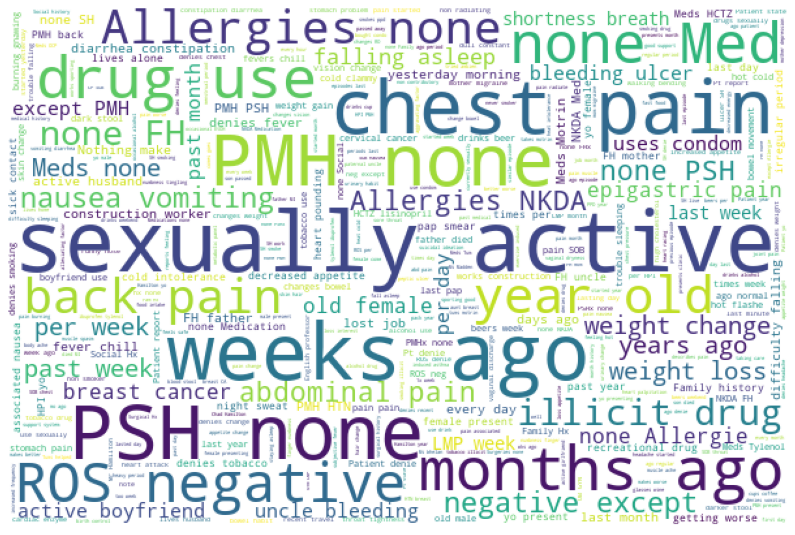

In [31]:
wordcloud_notes = wordcloud.WordCloud(stopwords=wordcloud.STOPWORDS, max_font_size=120, max_words=5000,
                      width = 600, height = 400,
                      background_color='white').generate(" ".join(all_notes))
fig, ax = plt.subplots(figsize=(14,10))
ax.imshow(wordcloud_notes, interpolation='bilinear')
ax.set_axis_off()
plt.imshow(wordcloud_notes);

* WORDCLOUD for Features

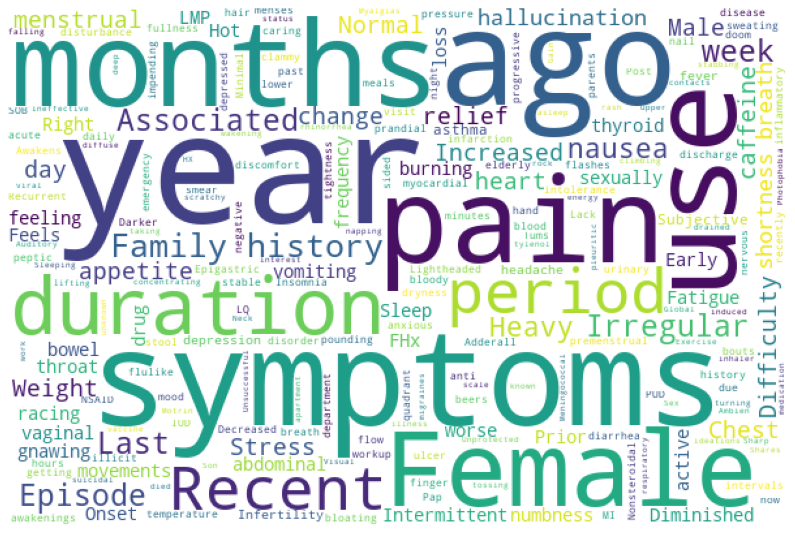

In [32]:
wordcloud_feat = wordcloud.WordCloud(stopwords=wordcloud.STOPWORDS, max_font_size=120, max_words=5000,
                      width = 600, height = 400,
                      background_color='white').generate(" ".join(all_feat))
fig, ax = plt.subplots(figsize=(14,10))
ax.imshow(wordcloud_feat, interpolation='bilinear')
ax.set_axis_off()
plt.imshow(wordcloud_feat);

* WORDCLOUD for Annotations

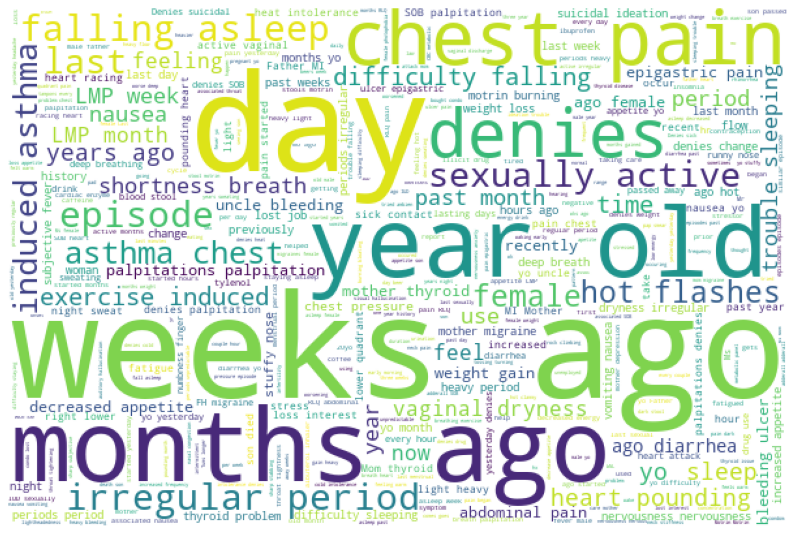

In [33]:
wordcloud_annot = wordcloud.WordCloud(stopwords=wordcloud.STOPWORDS, max_font_size=120, max_words=5000,
                      width = 600, height = 400,
                      background_color='white').generate(" ".join(all_annot_words))
fig, ax = plt.subplots(figsize=(14,10))
ax.imshow(wordcloud_annot, interpolation='bilinear')
ax.set_axis_off()
plt.imshow(wordcloud_annot);

* WORDCLOUD for two characters words in Patient notes

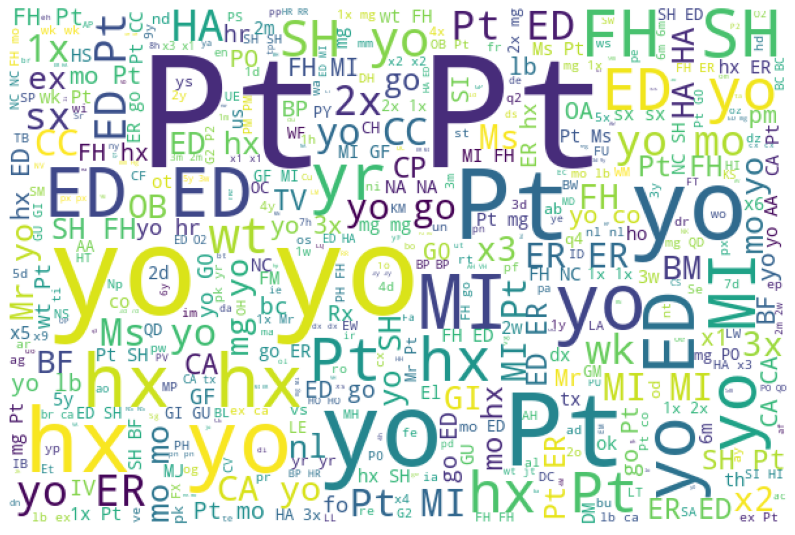

In [34]:
two  = []
for note in all_notes:
    for word in note.split():
        if len(word) == 2:
            two.append(word)
wordcloud_two_chars = wordcloud.WordCloud(stopwords=wordcloud.STOPWORDS, max_font_size=120, max_words=len(set(two)),
                      width = 600, height = 400,
                      background_color='white').generate(" ".join(two))
fig, ax = plt.subplots(figsize=(14,10))
ax.imshow(wordcloud_two_chars, interpolation='bilinear')
ax.set_axis_off()
plt.imshow(wordcloud_two_chars);

## Keyword Extraction
Thanks to [https://www.kaggle.com/emircanerol/keyword-extraction](https://www.kaggle.com/emircanerol/keyword-extraction).

* [Chinese Blog: Benchmarking of 7 main keyword extraction algorithms in Python, including rake-nltk & yake below](https://blog.csdn.net/deephub/article/details/121553254)

* [https://www.libhunt.com/compare-yake-vs-rake-nltk](https://www.libhunt.com/compare-yake-vs-rake-nltk)

In [42]:
!pip install yake
import yake

!pip install rake-nltk -q
from rake_nltk import Rake, Metric



import re
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [36]:
def process_tweet(tweet):
    '''
    Input:
        tweet: a string containing a tweet
    Output:
        tweets_clean: a list of words containing the processed tweet

    '''
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)
    
    tweets_clean = []
    for word in tweet_tokens:
        if (word not in stopwords_english and  # remove stopwords
            word not in string.punctuation):  # remove punctuation
            stem_word = stemmer.stem(word)  # stemming word
            tweets_clean.append(stem_word)

    note = ""
    for word in tweets_clean:
        note += word + " "
        
    return note


def merge(notes):
    notes.pn_history.str.lower()
    case = ["" for i in range(10)]

    for i, j in notes.iterrows():
        case[j.case_num] += j.pn_history + " "
    
    for i in range(len(case)):
        case[i] = process_tweet(case[i])
    
    return case


def yake_learn(cases, case_num):
    kw_extractor = yake.KeywordExtractor()
    keywords = kw_extractor.extract_keywords(cases[case_num])
    return keywords


def rake_learn(case):
    r = Rake(min_length=2, max_length=5, include_repeated_phrases=False, ranking_metric=Metric.WORD_DEGREE)
    r.extract_keywords_from_text(case)
    rake_results = r.get_ranked_phrases_with_scores()
    return rake_results

In [43]:
cases = merge(df_patient_notes)

yake_results = []
for i in range(10):
    sub_arr = []
    sub_arr.append(yake_learn(cases, i))
    yake_results.append(sub_arr)
    del sub_arr


rake_results = []
for i in range(10):
    sub_arr = []
    sub_arr.append(rake_learn(cases[i]))
    rake_results.append(sub_arr)
    del sub_arr

In [48]:
yake_results[0][0][0], rake_results[0][0][0]

(('episod heart pound', 7.990491559394445e-07),
 (5371.0, '3 month episod last 3'))

## More
https://www.kaggle.com/masato114/nbme-technical-terms-among-tokenizers.
The aim of this [notebook](https://www.kaggle.com/masato114/nbme-technical-terms-among-tokenizers) is to roughly explore how much techical terms in NBME features cannot be detected by various tokenizers, especially Roberta, DeBerta_V2 and PubMedBert